In [1]:
import numpy as np # 基础线性代数扩展包
import pandas as pd # 数据处理工具箱
df_bank = pd.read_csv("../input/bank-customer/BankCustomer.csv") # 读取文件
df_bank.head() # 显示文件前5行

,Name,Gender,Age,City,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,Exited
0,Kan Jian,Male,37,Tianjin,3,2,1,1,634,31937.37,137062,0
1,Xue Baochai,Female,39,Beijing,9,1,1,1,556,18144.95,110194,0
2,Mao Xi,Female,32,Beijing,9,1,1,1,803,10378.09,236311,1
3,Zheng Nengliang,Female,37,Tianjin,0,2,1,1,778,25564.01,129910,1
4,Zhi Fen,Male,55,Tianjin,4,3,1,0,547,3235.61,136976,1


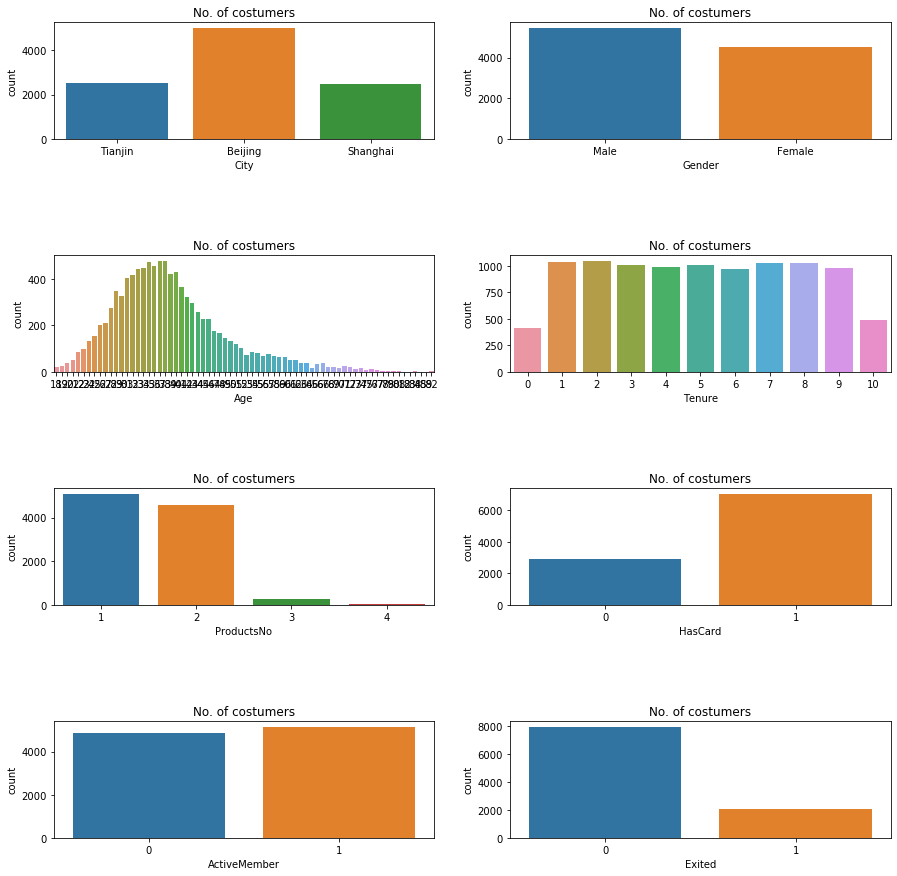

In [2]:
import matplotlib.pyplot as plt #导入matplotlib画图工具箱
import seaborn as sns #导入seaborn画图工具箱
# 显示不同特征的分布情况
features=[ 'City', 'Gender','Age','Tenure', 
           'ProductsNo', 'HasCard', 'ActiveMember', 'Exited']
fig=plt.subplots(figsize=(15,15))
for i, j in enumerate(features):
    plt.subplot(4, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.countplot(x=j,data = df_bank)
    plt.title("No. of costumers")

In [3]:
# 把二元类别文本数字化
df_bank['Gender'].replace("Female",0,inplace = True)
df_bank['Gender'].replace("Male",1,inplace=True)
# 显示数字类别
print("Gender unique values",df_bank['Gender'].unique())
# 把多元类别转换成多个二元哑变量，然后贴回原始数据集
d_city = pd.get_dummies(df_bank['City'], prefix = "City")
df_bank = [df_bank, d_city]
df_bank = pd.concat(df_bank, axis = 1)
# 构建特征和标签集合
y = df_bank['Exited']
X = df_bank.drop(['Name', 'Exited', 'City'], axis=1)
X.head() #显示新的特征集

Gender unique values [1 0]


,Gender,Age,Tenure,ProductsNo,HasCard,ActiveMember,Credit,AccountBal,Salary,City_Beijing,City_Shanghai,City_Tianjin
0,1,37,3,2,1,1,634,31937.37,137062,0,0,1
1,0,39,9,1,1,1,556,18144.95,110194,1,0,0
2,0,32,9,1,1,1,803,10378.09,236311,1,0,0
3,0,37,0,2,1,1,778,25564.01,129910,0,0,1
4,1,55,4,3,1,0,547,3235.61,136976,0,0,1


In [4]:
from sklearn.model_selection import train_test_split # 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                   test_size=0.2, random_state=0)

In [6]:
# 对多棵决策树进行Bagging，即树的聚合
from sklearn.ensemble import BaggingClassifier # 导入Bagging分类器
from sklearn.tree import DecisionTreeClassifier # 导入决策树分类器
from sklearn.metrics import (f1_score, confusion_matrix) # 导入评估标准
dt = DecisionTreeClassifier() # 只使用一棵决策树
dt.fit(X_train, y_train) # 拟合模型
y_pred = dt.predict(X_test) # 进行预测
print("决策树测试准确率: {:.2f}%".format(dt.score(X_test, y_test)*100))
print("决策树测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))
bdt = BaggingClassifier(DecisionTreeClassifier()) #树的Bagging
bdt.fit(X_train, y_train) # 拟合模型
y_pred = bdt.predict(X_test) # 进行预测
print("决策树Bagging测试准确率: {:.2f}%".format(bdt.score(X_test, y_test)*100))
print("决策树Bagging测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

决策树测试准确率: 84.70%
决策树测试F1分数: 56.66%
决策树Bagging测试准确率: 85.45%
决策树Bagging测试F1分数: 57.76%


In [8]:
from sklearn.model_selection import GridSearchCV # 导入网格搜索工具
# 使用网格搜索优化参数
bdt_param_grid = {
    'base_estimator__max_depth' : [5,10,20,50,100],
    'n_estimators' : [1, 5, 10, 50]}
bdt_gs = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                   param_grid = bdt_param_grid, scoring = 'f1',
                   n_jobs= 10, verbose = 1)
bdt_gs.fit(X_train, y_train) # 拟合模型
bdt_gs = bdt_gs.best_estimator_ # 最佳模型
y_pred = bdt.predict(X_test) # 进行预测
print("决策树Bagging测试准确率: {:.2f}%".format(bdt_gs.score(X_test, y_test)*100)) 
print("决策树Bagging测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    9.8s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:   29.6s finished


决策树Bagging测试准确率: 86.25%
决策树Bagging测试F1分数: 57.76%


In [10]:
from sklearn.ensemble import RandomForestClassifier # 导入随机森林分类器
rf = RandomForestClassifier() # 随机森林模型
# 使用网格搜索优化参数
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
               "min_samples_split": [2, 3, 10],
               "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True,False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
rf_gs = GridSearchCV(rf,param_grid = rf_param_grid, 
                     scoring="f1", n_jobs= 10, verbose = 1)
rf_gs.fit(X_train,y_train) # 拟合模型
rf_gs = rf_gs.best_estimator_ # 最佳模型
y_pred = rf_gs.predict(X_test) # 进行预测
print("随机森林测试准确率: {:.2f}%".format(rf_gs.score(X_test, y_test)*100))
print("随机森林测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100)) 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   26.9s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.2min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed: 10.5min
[Parallel(n_jobs=10)]: Done 540 out of 540 | elapsed: 17.0min finished


随机森林测试准确率: 86.50%
随机森林测试F1分数: 60.18%


In [12]:
from sklearn.ensemble import ExtraTreesClassifier # 导入极端随机森林模型
ext = ExtraTreesClassifier() # 极端随机森林模型
# 使用网格搜索优化参数
ext_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True,False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}
ext_gs = GridSearchCV(ext,param_grid = ext_param_grid, scoring="f1", 
                     n_jobs= 4, verbose = 1)
ext_gs.fit(X_train,y_train) # 拟合模型
ext_gs = ext_gs.best_estimator_ # 最佳模型
y_pred = ext_gs.predict(X_test) # 进行预测
print("更多树测试准确率: {:.2f}%".format(ext_gs.score(X_test, y_test)*100))
print("更多树测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:  7.5min finished


更多树测试准确率: 86.50%
更多树测试F1分数: 59.34%


In [14]:
from sklearn.ensemble import AdaBoostClassifier # 导入AdaBoost模型
dt = DecisionTreeClassifier() # 选择决策树分类器作为AdaBoost的基准算法
ada = AdaBoostClassifier(dt) # AdaBoost模型
# 使用网格搜索优化参数
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
                  "base_estimator__splitter" :   ["best", "random"],
                  "base_estimator__random_state" :   [7,9,10,12,15],
                  "algorithm" : ["SAMME","SAMME.R"],
                  "n_estimators" :[1,2,5,10],
                  "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
ada_gs = GridSearchCV(ada,param_grid = ada_param_grid, 
                        scoring="f1", n_jobs= 10, verbose = 1)
ada_gs.fit(X_train,y_train) # 拟合模型
ada_gs = ada_gs.best_estimator_ # 最佳模型
y_pred = ada_gs.predict(X_test) # 进行预测
print("Adaboost测试准确率: {:.2f}%".format(ada_gs.score(X_test, y_test)*100))
print("Adaboost测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

Fitting 5 folds for each of 1120 candidates, totalling 5600 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.6s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    9.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   16.5s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   25.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   39.0s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   59.0s
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done 4980 tasks      | elapsed:  2.8min


Adaboost测试准确率: 78.85%
Adaboost测试F1分数: 47.71%


[Parallel(n_jobs=10)]: Done 5600 out of 5600 | elapsed:  3.2min finished


In [16]:
from sklearn.ensemble import GradientBoostingClassifier # 导入梯度提升分类器
gb = GradientBoostingClassifier() # 梯度提升分类器
# 使用网格搜索优化参数
gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [100,200,300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100,150],
                 'max_features': [0.3, 0.1]}
gb_gs = GridSearchCV(gb,param_grid = gb_param_grid,
                     scoring="f1", n_jobs= 10, verbose = 1)
gb_gs.fit(X_train,y_train) # 拟合模型
gb_gs = gb_gs.best_estimator_ # 最佳模型
y_pred = gb_gs.predict(X_test) # 进行预测
print("梯度提升测试准确率: {:.2f}%".format(gb_gs.score(X_test, y_test)*100))
print("梯度提升测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   20.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 360 out of 360 | elapsed:  4.3min finished


梯度提升测试准确率: 86.50%
梯度提升测试F1分数: 60.64%


In [18]:
from xgboost import XGBClassifier # 导入XGB分类器
xgb = XGBClassifier() # XGB分类器
# 使用网格搜索优化参数
xgb_param_grid = {'min_child_weight': [1, 5, 10],
                  'gamma': [0.5, 1, 1.5, 2, 5],
                  'subsample': [0.6, 0.8, 1.0],
                  'colsample_bytree': [0.6, 0.8, 1.0],
                  'max_depth': [3, 4, 5]}
xgb_gs = GridSearchCV(xgb,param_grid = xgb_param_grid,  
                     scoring="f1", n_jobs= 10, verbose = 1)
xgb_gs.fit(X_train,y_train) # 拟合模型
xgb_gs = xgb_gs.best_estimator_ # 最佳模型
y_pred = xgb_gs.predict(X_test) # 进行预测
print("XGB测试准确率: {:.2f}%".format(xgb_gs.score(X_test, y_test)*100))
print("XGB测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   14.5s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  1.0min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  4.3min
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:  6.9min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed: 10.6min
[Parallel(n_jobs=10)]: Done 2025 out of 2025 | elapsed: 12.3min finished


XGB测试准确率: 86.30%
XGB测试F1分数: 60.17%


In [20]:
from sklearn.ensemble import  VotingClassifier # 导入Voting分类器
# 把各种模型的分类结果进行Voting，同学们还可以加入更多模型如SVM，kNN等
voting = VotingClassifier(estimators=[('rf', rf_gs),
                                      ('gb',gb_gs),
                                      ('ext', ext_gs),
                                      ('xgb', xgb_gs),
                                      ('ada', ada_gs)],

                          voting='soft', n_jobs=10)
voting = voting.fit(X_train, y_train) # 拟合模型
y_pred = voting.predict(X_test) # 进行预测
print("Voting测试准确率: {:.2f}%".format(voting.score(X_test, y_test)*100)) 
print("Voting测试F1分数: {:.2f}%".format(f1_score(y_test, y_pred)*100))

Voting测试准确率: 86.35%
Voting测试F1分数: 60.49%
